<a href="https://colab.research.google.com/github/zhuhel/RPC_TOF_NN/blob/main/RPC_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim
import torch    # for setting seed to make it reproducible
import torch.nn as nn
import matplotlib.pyplot as plt  # for plotting
import matplotlib.mlab as mlab  # for plotting
import struct  # for binary file reading
import numpy as np
import time  # for time recording
import math  # for sqrt
from pathlib import Path  # for the size of the binary file
from scipy.stats import norm  # for gaussian fit
import sys  # for parameter receiving
import os  # for mkdir
from progressbar import *

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
time_start = time.time()
time_epoch = time.time()

SEED=5  # reproducible
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
SAMPLE_EPOCH = 1  # test every xx epochs to record mu, timeresolution, and loss
EPOCHS = 100

MODEL_VERSION = '930'
DATA_VERSION = 'Aug-200_900_6'
WAVE_LENGTH = 160
NCHANNEL = 2

LR = 0.0001 + 0.0009*np.random.rand()
LRD = 0.9 + 0.1*np.random.rand()
BATCH_SIZE = 256
DROP_OUT = 0.0
WEIGHT_DECAY = 0.0004 + 0.0004*np.random.rand()  # lambda of L2 regularization

In [ ]:
class Waveforms(Dataset):
    def __init__(self, root_dir, testRate = 0.3, train=True):
        self.root_dir = root_dir
        self.train = train
        self.file = open(root_dir, 'rb')
        self.waveLength = WAVE_LENGTH
        self.NChannel = NCHANNEL
        self.NEvents = Path(self.root_dir).stat().st_size / \
            (self.waveLength*self.NChannel+1)/4
        print('NEvents = ', self.NEvents)
        self.testRaio = testRate

    def __len__(self):
        if self.train:
            return int(self.NEvents*(1.0-self.testRaio))
        else:
            return int(self.NEvents*self.testRaio)

    def __getitem__(self, index):
        if self.train:
            self.file.seek((index+int(self.NEvents*self.testRaio))
                           * (self.NChannel*self.waveLength+1)*4, 0)
        else:
            self.file.seek((index)*(self.NChannel*self.waveLength+1)*4, 0)
        data = self.file.read(self.waveLength*self.NChannel*4)
        wave = struct.unpack(str(self.NChannel*self.waveLength)+'f', data)
        #wave_tensor = torch.tensor(wave, dtype=torch.float32).reshape(1, self.NChannel, self.waveLength)
        wave_tensor = torch.tensor(wave, dtype=torch.float32)
        data = self.file.read(4)
        tof = struct.unpack('f', data)
        tof_tensor = torch.tensor(tof, dtype=torch.float32)
        sample = {'waveform': wave_tensor, 'tof': tof_tensor}
        return sample

In [ ]:
######################################################################
## Define CNN network
######################################################################

class MLP(nn.Module):
    def __init__(self, input_size, common_size):
        super(MLP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(inplace=True),
            nn.Linear(input_size, input_size // 4),
            nn.ReLU(inplace=True),
            nn.Linear(input_size // 4, common_size)
        )

    def forward(self, x):
        out = self.linear(x)
        return out

class CNNnet(nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.waveLength = WAVE_LENGTH
        self.NChannel = NCHANNEL
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1,
                            out_channels=16,
                            kernel_size=2,
                            stride=1,
                            padding=0),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,2,1,0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.out1 = torch.nn.Linear((self.waveLength-2)*(self.NChannel-2)*32, 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.out1(x.view(x.size(0),-1))
        return x


In [ ]:
########################################################################################
## INPUT/OUTPUT PATH SETTING ########
########################################################################################

workspace = '/content/gdrive/My Drive/RPC_TOF/'
fileName = workspace+"/data_6/"+DATA_VERSION+".bin"
outputPath = workspace+DATA_VERSION+"_"+MODEL_VERSION+"_Aug25th_mlp/"
if os.path.exists(outputPath) == False:
    os.mkdir(outputPath)
outputPrefix = DATA_VERSION+"_SEED"+str(SEED).zfill(4) + "_E"+str(EPOCHS)

if False:
  print('workspace:',workspace,os.path.exists(workspace))
  print('fileName:',fileName,os.path.exists(fileName))
  print('outputPath:',outputPath,os.path.exists(outputPath))

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla K80


In [ ]:
def testDataset(network, dataVersion, outputPrefix, input_prefix = "./Codes/V0.70/Data/"):
    inputFileName = input_prefix+dataVersion+".bin"
    testWaveformDataset = Waveforms(inputFileName, testRate = 1.0, train=False)
    testData = DataLoader(testWaveformDataset,
                          batch_size=BATCH_SIZE, shuffle=False)

    residualTofList = []
    predictedTofList = []
    labelTofList = []
    print("Test Data: " + dataVersion)
    mu=sigma=0
    with torch.no_grad( ):
        for index, batch_data in enumerate(testData):
            input = Variable(batch_data['waveform']).cuda()
            b_y = Variable(batch_data['tof']).cuda().squeeze()
            output = model(input).squeeze()
            residualTofList.extend(
                (output-b_y).cpu().detach().numpy().tolist())
            predictedTofList.extend(output.cpu().detach().numpy().tolist())
            labelTofList.extend(b_y.cpu().detach().numpy().tolist())

    (mu, sigma) = norm.fit(residualTofList)
    n, bins, patches = plt.hist(residualTofList, 50, range=(-2, 2), density=1)
    # add a 'best fit' line
    y = norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth=2)
    plt.xlabel('Tof residual [ns]')
    plt.title(
        r'$\mathrm{Tof\ residual:}\ \mu=%.3f ns,\ \sigma/\sqrt{2}=%.3f ns$' % (mu, sigma/math.sqrt(2)))
    plt.grid(True)
    plt.savefig(outputPath + outputPrefix +
                "Test_" + dataVersion + ".png")
    plt.clf()


def my_mse_loss(x, y, n): 
    return torch.mean(torch.pow(torch.abs(x - y), n))


In [ ]:
########################################################################################
## EXCUTION:Training ########
########################################################################################


trainWaveformDataset = Waveforms(fileName, train=True)
testWaveformDataset = Waveforms(fileName, train=False)
trainData = DataLoader(trainWaveformDataset, batch_size=BATCH_SIZE, shuffle=True)
testData = DataLoader(testWaveformDataset, batch_size=BATCH_SIZE, shuffle=False)

model = MLP(NCHANNEL*WAVE_LENGTH,1)
model.cuda()
print(model)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LRD)
print(optimizer)
# loss_func = nn.MSELoss().cuda()
loss_func = my_mse_loss

NEvents =  7815.0
NEvents =  7815.0
MLP(
  (linear): Sequential(
    (0): Linear(in_features=320, out_features=320, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=320, out_features=80, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=80, out_features=1, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0002997938539807655
    weight_decay: 0.00048268766213577056
)


torch.Size([8, 160])


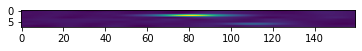

In [ ]:
import torchvision

batch_data = next(iter(trainData))
images = batch_data['waveform'][111][0]
print(images.shape)
#images_example=torchvision.utils.make_grid(images)
#print(images_example.shape)
#images_example=images_example.numpy().transpose(1,2,0)
#mean=0.5
#std=0.5
#images_example=images_example*std+mean
plt.imshow(images)
plt.show()

In [ ]:
batch_data = next(iter(trainData))
batch_data['waveform'].shape

torch.Size([256, 320])

In [ ]:
testLoss_his = []
trainLoss_his = []
timeResolution_his = []
mu_his = []
residualTofList = []
predictedTofList = []
labelTofList = []

print("Data: " + DATA_VERSION + "; SEED = " + str(SEED)+"； Epochs = " + str(EPOCHS))
progress = ProgressBar()
for epoch in progress(range(EPOCHS)):
    epoch_loss = 0  # for LR decay rate scheduler
    for index, batch_data in enumerate(trainData):
        input = Variable(batch_data['waveform']).cuda()
        b_y = Variable(batch_data['tof']).cuda().squeeze()
        #print(input.size())
        output = model(input).squeeze()
        #print(output.size())
        loss = loss_func(output, b_y, 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.data.cpu().numpy()
    scheduler.step(epoch_loss)

    # to store the sigma, mu, loss
    if (epoch) % SAMPLE_EPOCH == 0:
        trainLoss_his.append(loss.data.cpu().numpy())
        residualTofList.clear()
        predictedTofList.clear()
        labelTofList.clear()
        for index, batch_data in enumerate(testData):
            input = Variable(batch_data['waveform']).cuda()
            b_y = Variable(batch_data['tof']).cuda().squeeze()
            output = model(input).squeeze()
            loss = loss_func(output, b_y, 2)
            residualTofList.extend(
                (output-b_y).cpu().detach().numpy().tolist())
            predictedTofList.extend(output.cpu().detach().numpy().tolist())
            labelTofList.extend(b_y.cpu().detach().numpy().tolist())
            # print('output length: ',output.cpu().detach().numpy().tolist().__len__())
        # print('toflist length: ',tofList.__len__())
        (mu, sigma) = norm.fit(residualTofList)
        timeResolution_his.append(sigma/math.sqrt(2))
        mu_his.append(mu)
        testLoss_his.append(loss.data.cpu().numpy())
        if (epoch) % 40 == 0: print("Test Loss: ", testLoss_his[-1])


# save model
torch.save(model, outputPath+outputPrefix)

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Data: Aug-200_900_6; SEED = 5； Epochs = 100


  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:37

Test Loss:  0.73553205


 41% (41 of 100) |#########              | Elapsed Time: 0:00:13 ETA:   0:00:20

Test Loss:  0.29735693


 81% (81 of 100) |##################     | Elapsed Time: 0:00:27 ETA:   0:00:06

Test Loss:  0.36072722


100% (100 of 100) |######################| Elapsed Time: 0:00:33 Time:  0:00:33


In [ ]:
########################################################################################
## EXCUTION:Plotting ########
########################################################################################
time_start = time.time()
plt.plot(testLoss_his, label='testLoss')
plt.plot(trainLoss_his, label='trainLoss')
plt.grid(True)
# plt.ylim([0.01, 0.08])
# plt.ylabel("MSE [ns^2]")
plt.title("Loss/MSE Vs Epochs")
plt.xlabel("sampled every "+str(SAMPLE_EPOCH)+" epochs")
plt.legend()
plt.savefig(outputPath+outputPrefix+"_Loss.png")
plt.clf()

plt.plot(mu_his)
plt.grid(True)
plt.title("Average predicted ToF Vs Epochs")
plt.ylabel("Average of predicted ToF [ns]")
plt.ylim([-0.1, 0.1])
plt.xlabel("sampled every "+str(SAMPLE_EPOCH)+" epochs")
plt.savefig(outputPath+outputPrefix+"_Mu.png")
plt.clf()

plt.plot(timeResolution_his)
plt.ylabel("Time Resolution [ns]")
plt.grid(True)
plt.ylim([0.05, 0.30])
plt.title("TimeResolution Vs Epochs")
plt.xlabel("sampled every "+str(SAMPLE_EPOCH)+" epochs")
plt.savefig(outputPath+outputPrefix+"_TR.png")
plt.clf()

(mu, sigma) = norm.fit(residualTofList)
n, bins, patches = plt.hist(residualTofList, 100, range=(-1, 1), density=1)
# add a 'best fit' line
y = norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Tof residual [ns]')
# plt.ylabel('Probability')
plt.title(r'$\mathrm{Tof\ residual:}\ \mu=%.3f ns,\ \sigma/\sqrt{2}=%.3f ns$' %(mu, sigma/math.sqrt(2)))
plt.grid(True)
plt.savefig(outputPath+outputPrefix+"_TofHist.png")
plt.clf()

#for dataVersion in ['247_4','359_4']:
for dataVersion in ['300_6','345_6']:
    testDataset(model, dataVersion, outputPrefix, input_prefix=workspace+"/data_6/")

time_end = time.time()
print('time cost', time_end-time_start, 's')

NEvents =  4278.0
Test Data: 300_6
NEvents =  3538.0
Test Data: 345_6
time cost 1.633812665939331 s


<Figure size 432x288 with 0 Axes>